In [1]:
import pandas as pd
import json
from neo4j import GraphDatabase

In [2]:
data = pd.read_csv('data_test.csv', delimiter=';')
data.head()

,id события,ФИО участника события 1,ФИО участника события 2
0,189,Галчевская Карина Владимировна,Белоновская Анастасия Семеновна
1,206,Офицеров Олег Романович,Сапожник Борис Валерьевич
2,445,Жандарова Лариса Германовна,Чемодуров Дамир Русланович
3,503,Масимова Яна Дамировна,Мингажетдинов Рамиль Семенович
4,571,Мухтарова Алена Яковлевна,Щербатенко Ольга Робертовна


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id события               5000 non-null   int64 
 1   ФИО участника события 1  5000 non-null   object
 2   ФИО участника события 2  5000 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [4]:
data['ФИО участника события 1'].value_counts()

Ахромеева Алина Ивановна          49
Башнина Антонина Глебовна         14
Диомидов Игорь Ильдарович          5
Зимнухова Карина Даниловна         4
Пафомова Кира Вадимовна            2
                                  ..
Серафимина Екатерина Никитовна     1
Башмашников Тимур Рамилевич        1
Онищин Федор Аркадьевич            1
Речкалов Марсель Антонович         1
Ряполовский Георгий Петрович       1
Name: ФИО участника события 1, Length: 4930, dtype: int64

In [5]:
data['ФИО участника события 2'].value_counts()

Медведева Дарья Алексеевна          5
Двигубская Валентина Геннадьевна    2
Шолохов Игорь Робертович            2
Белоновская Анастасия Семеновна     1
Шлякова Маргарита Алексеевна        1
                                   ..
Фомич Семен Ильич                   1
Коковкина Валерия Дамировна         1
Токранов Данил Степанович           1
Аврелин Сергей Кириллович           1
Жилейкин Виктор Павлович            1
Name: ФИО участника события 2, Length: 4994, dtype: int64

In [6]:
data['id события'].value_counts()

850472    2
358194    2
70049     2
117280    2
523688    2
         ..
333793    1
333694    1
333678    1
333635    1
999878    1
Name: id события, Length: 4985, dtype: int64

In [7]:
data[data['id события'] == 850472]

,id события,ФИО участника события 1,ФИО участника события 2
4250,850472,Стрик Элина Марселевна,Борчин Павел Робертович
4251,850472,Ахромеева Алина Ивановна,Ларищев Илья Александрович


In [8]:
data[data['ФИО участника события 2'].str.contains("Ахромеева")]

,id события,ФИО участника события 1,ФИО участника события 2
4021,800116,Ошуров Павел Ильдарович,Ахромеева Алина Ивановна


In [9]:
data_array = data.values

In [10]:
class App:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def create_relations(self, person1_name, person2_name, id_event):
        with self.driver.session() as session:
            result = session.execute_write(
                self._create_and_return_friendship, person1_name, person2_name, id_event)

    @staticmethod
    def _create_and_return_friendship(tx, person1_name, person2_name, id_event):
        query = (
            "CREATE (p1:Person { name: $person1_name }) "
            "CREATE (p2:Person { name: $person2_name }) "
            "CREATE (p1)-[:RELATED {id_event: $id_event }]->(p2) "
        )
        result = tx.run(query, person1_name=person1_name, person2_name=person2_name, id_event=id_event)

    def find_person(self, person_name):
        with self.driver.session() as session:
            result = session.execute_read(self._find_and_return_person, person_name)
            for record in result:
                print(json.dumps(record, indent=3, ensure_ascii=False))
            # Для вывода обычной форматированной строки
            #for record in result:
                #print("Found person: {name}, event: {event}".format(
                    #name=record['name'], event=record['event']))

    @staticmethod
    def _find_and_return_person(tx, person_name):
        query = (
            "MATCH (p:Person {name:$person_name})<-[n:RELATED]->(m)"
            "RETURN m.name AS name, n.id_event AS event"
        )
        result = tx.run(query, person_name=person_name)
        return [{"name": record["name"], "event": record["event"]} for record in result]

if __name__ == "__main__":
    scheme = "bolt"
    host_name = "localhost"
    port = 7687
    url = f"{scheme}://{host_name}:{port}"
    user = "neo4j"
    password = "data_test"
    app = App(url, user, password)
    try:
        # Вызов функции для создания базы
        #[app.create_relations(record[1], record[2], record[0]) for record in data_array]
        person = input().title()
        app.find_person(person)
    finally:
        app.close()

Ошуров Павел Ильдарович
{
   "name": "Ахромеева Алина Ивановна",
   "event": 800116
}


**Визуальное отображение системы графов получившейся базы:**

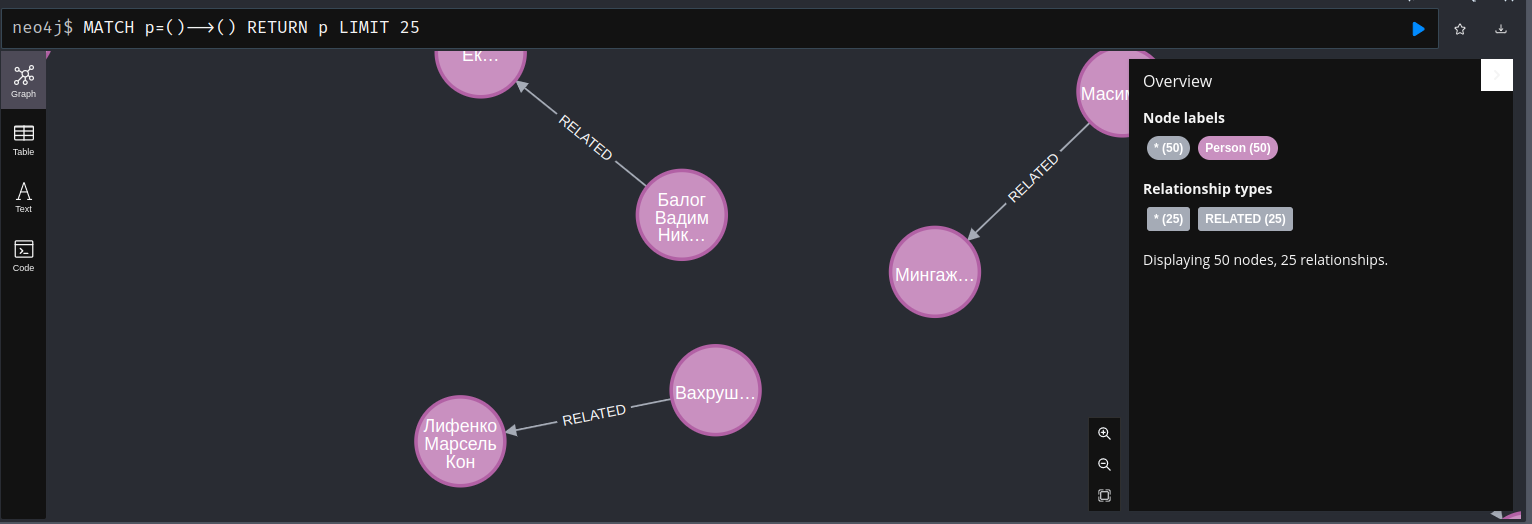

**Для некоторых фамилий обнаружено совпадение в парах более одного раза:**

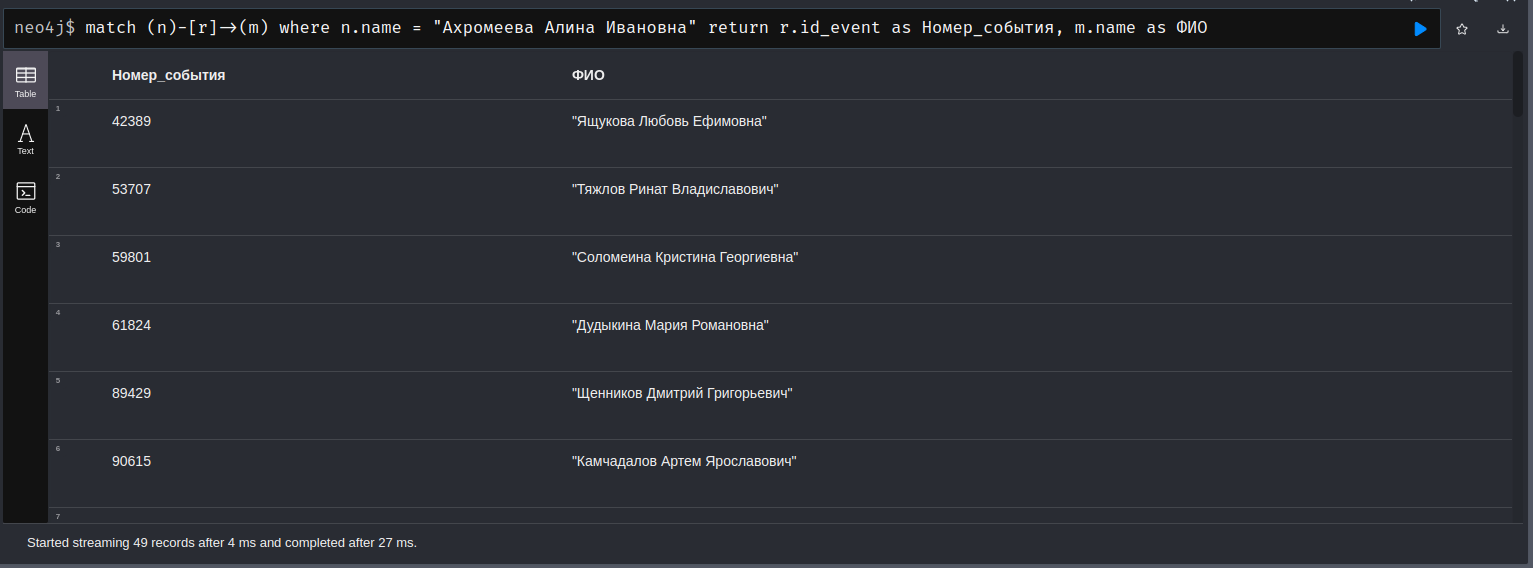

**Подсчет количества имен, встречающихся в базе более одного раза:**

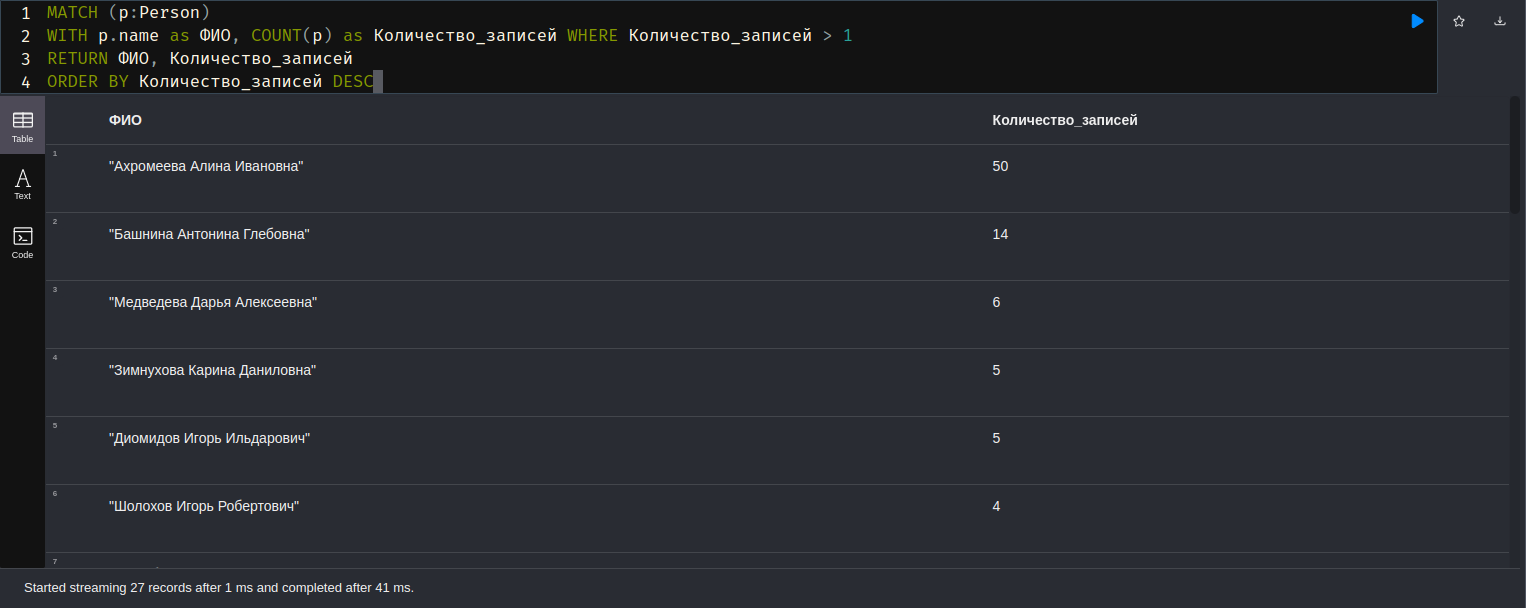